# Music Genre Classification with CNN #

## Introduction ##

The goal of this work is to build a machine learning model able to classify samples of audio files in different music genres.

We used a Convolutional Neural Network, which performed better than most models according to the literature on the matter, even outperforming the benchmark for human accuracy, which averages around 70%.

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#!{sys.executable} -m pip install librosa
import librosa
import librosa.display
import IPython

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#!{sys.executable} -m pip install tensorflow
from tensorflow import keras as k

## Dataset ##

To train our model we used the GTZAN dataset, which includes:
    
* Genres original - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds;
* Images original - A visual representation for each audio file. The audio files were converted to Mel Spectrograms to make this possible;
* 2 CSV files - One has for each song a mean and variance computed over multiple features that can be extracted from an audio file. The other has the same structure, but the songs were split before into 3 seconds audio files, increasing 10 times the amount of data.

The 10 genres included in our training and evaluation of the model are: 

* Classical
* Country
* Disco
* Hip-hop
* Jazz
* Metal 
* Pop
* Reggae 
* Rock


In [58]:
df = pd.read_csv("Dataset/features_3_sec.csv") # read features
df = df.drop(labels='filename', axis=1) # drop the first column

df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


## Visual representation ## 

To recognize patterns related to music genres using CNN, a straight forward approch was to represent visual features of each sample, capturing musical differences on amplitude, frequency and energy spectrum and using the convolutional layers of the model to identify patterns within images.

Already having in the dataset the Mel Spectrograms of each audio file makes the training phase faster than having to compute it on the run. 

Nevertheless, to help us understand the data we are working on, we used the *Librosa* library, which provides the building blocks necessary to create music information retrieval systems.

In [3]:
sr = 22050 # sampling rate

metal = "Dataset/genres_original/metal/metal.00000.wav"
metal_series, sr = librosa.load(metal) # decode the audio files as a time series

classical = "Dataset/genres_original/classical/classical.00000.wav"
classical_series, sr = librosa.load(classical)

hiphop = "Dataset/genres_original/hiphop/hiphop.00000.wav"
hiphop_series, sr = librosa.load(hiphop)

In [45]:
IPython.display.Audio(metal_series, rate=sr) # play audio

### Waveform ###

Waveform graphs plot amplitude against time. 

The amplitude indicates the strength of the vibration the sound is causing to the air. The time is the speed at which the variations are occurring. 

The shape of the wave shows the pattern of the vibration, meaning the timbre of the sound. 

Librosa's function converts a raw samples-based view of the signal to the amplitude-envelope view of the signal depending on the time extent of the plot’s viewport.

[Text(0.5, 1.0, 'Hip-hop waveform')]

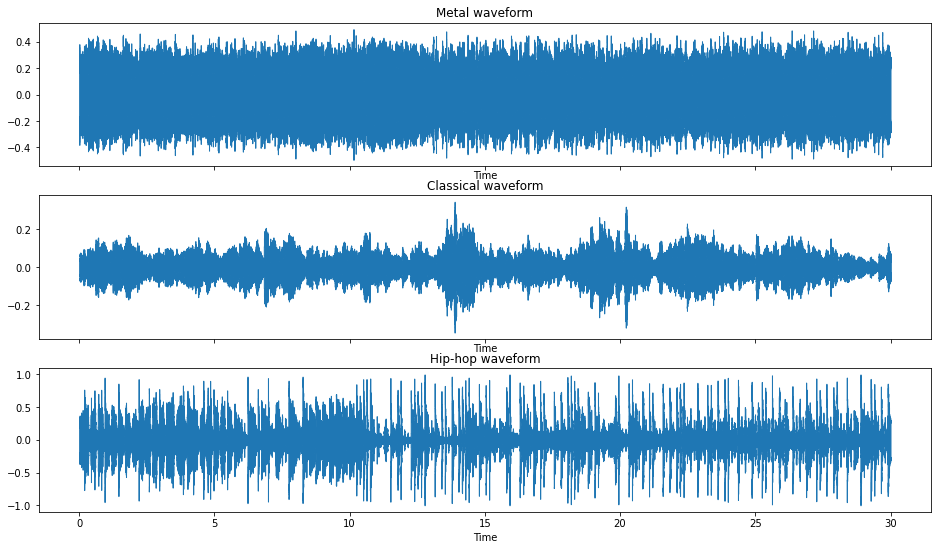

In [64]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), sharex=True)

# First subplot: metal
img1 = librosa.display.waveshow(metal_series, x_axis='time', ax=ax[0]) # Visualize a waveform in the time domain
ax[0].set(title='Metal waveform')

# Second subplot: classical
img2 = librosa.display.waveshow(classical_series, x_axis='time', ax=ax[1])
ax[1].set(title='Classical waveform')

# Third subplot: hip-hop
img3 = librosa.display.waveshow(hiphop_series, x_axis='time', ax=ax[2])
ax[2].set(title='Hip-hop waveform')

### Spectral Features ###

#### Mel Spectrogram ####

Mel-spectrograms are a commonly used method of featurizing audio for their close representation of human perception of audio.

To convert a raw audio to mel-spectrogram, the first thing to do is to apply the short-time Fourier transforms (STFT). The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.

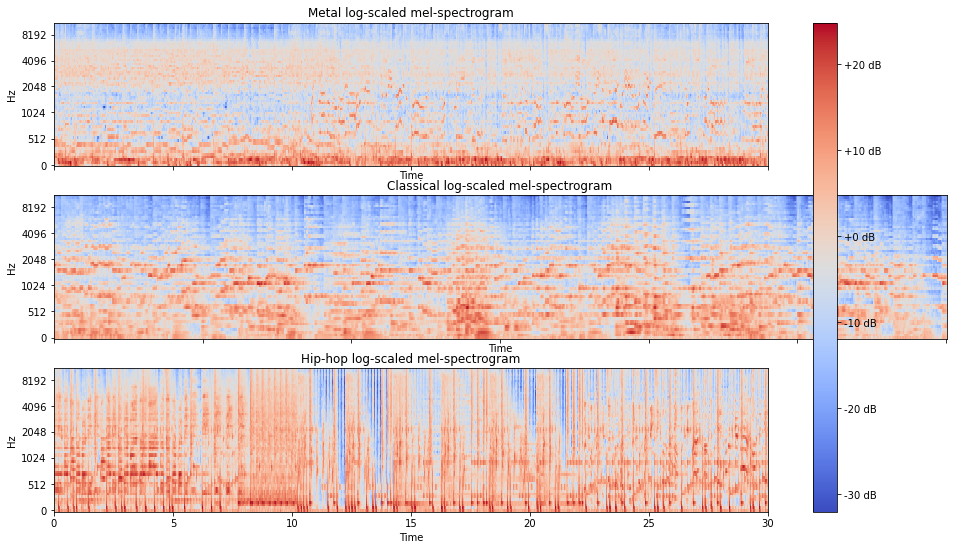

In [4]:
mel_1 = librosa.feature.melspectrogram(y=metal_series, sr=sr, n_fft=2048, hop_length=512, n_mels=64, fmax=8000)
log_mel_1 = librosa.power_to_db(mel_1)

mel_2 = librosa.feature.melspectrogram(y=classical_series, sr=sr, n_fft=2048, hop_length=512, n_mels=64, fmax=8000)
log_mel_2 = librosa.power_to_db(mel_2)

mel_3 = librosa.feature.melspectrogram(y=hiphop_series, sr=sr, n_fft=2048, hop_length=512, n_mels=64, fmax=8000)
log_mel_3 = librosa.power_to_db(mel_3)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), sharex=True)

# First subplot: metal
img1 = librosa.display.specshow(log_mel_1, x_axis='time', y_axis='mel', ax=ax[0])
ax[0].set(title='Metal log-scaled mel-spectrogram')

# Second subplot: classical
img2 = librosa.display.specshow(log_mel_2, x_axis='time', y_axis='mel', ax=ax[1])
ax[1].set(title='Classical log-scaled mel-spectrogram')

# Third subplot: hip-hop
img3 = librosa.display.specshow(log_mel_3, x_axis='time', y_axis='mel', ax=ax[2])
ax[2].set(title='Hip-hop log-scaled mel-spectrogram')

fig.colorbar(img1, ax=[ax[0], ax[2]], format="%+2.f dB")

#### Chromagram ####

A chromagram represents chroma-based features, used to analyze music whose pitches can be meaningfully categorized. They capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.

The underlying observation is that humans perceive two musical pitches as similar in color if they differ by an octave. Based on this observation, a pitch can be separated into two components, which are referred to as tone height and chroma.

Librosa provides functions to compute a chromagram, from a waveform or power spectrogram, which aggregates information across all frequencies corresponding to a given pitch class.

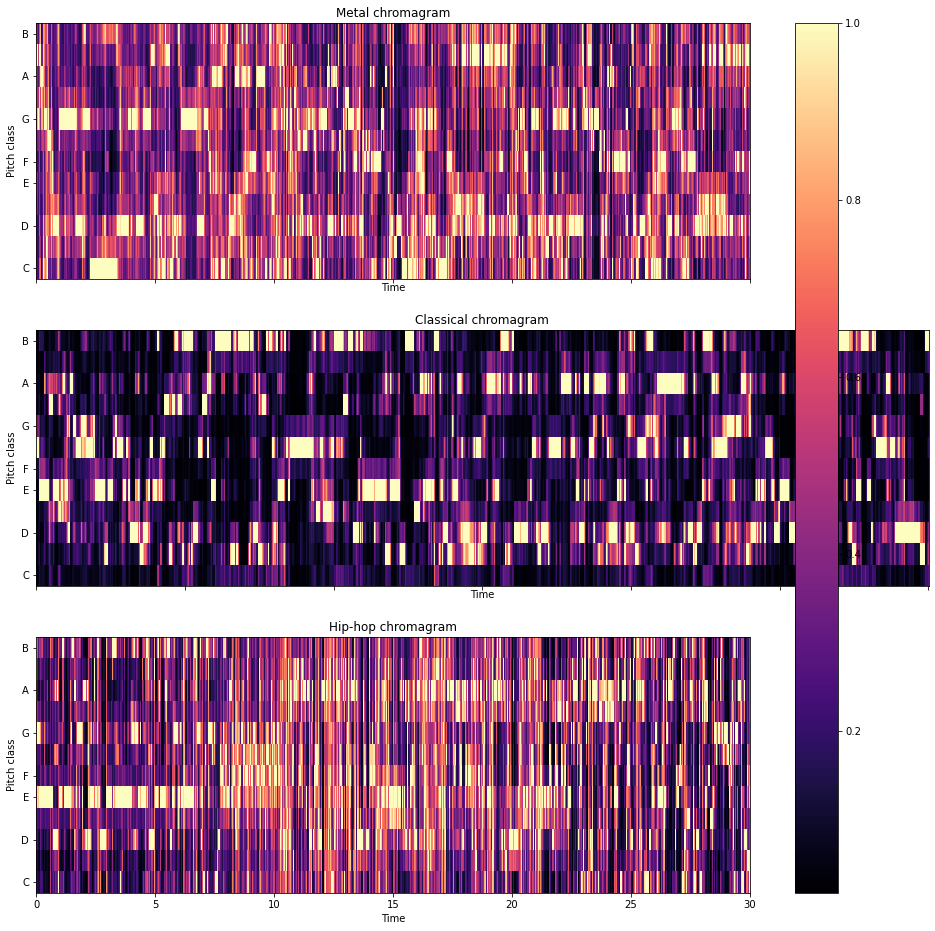

In [8]:
chroma_1 = librosa.feature.chroma_stft(y=metal_series, sr=sr) # Compute the chromagram
chroma_2 = librosa.feature.chroma_stft(y=classical_series, sr=sr)
chroma_3 = librosa.feature.chroma_stft(y=hiphop_series, sr=sr)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 16), sharex=True)

img1 = librosa.display.specshow(chroma_1, sr=sr, x_axis='time', y_axis='chroma', ax=ax[0])
ax[0].set(title='Metal chromagram')

img2 = librosa.display.specshow(chroma_2, sr=sr, x_axis='time', y_axis='chroma', ax=ax[1])
ax[1].set(title='Classical chromagram')

img3 = librosa.display.specshow(chroma_3, sr=sr, x_axis='time', y_axis='chroma', ax=ax[2])
ax[2].set(title='Hip-hop chromagram')

plt.colorbar(img1, ax=[ax[0], ax[2]])

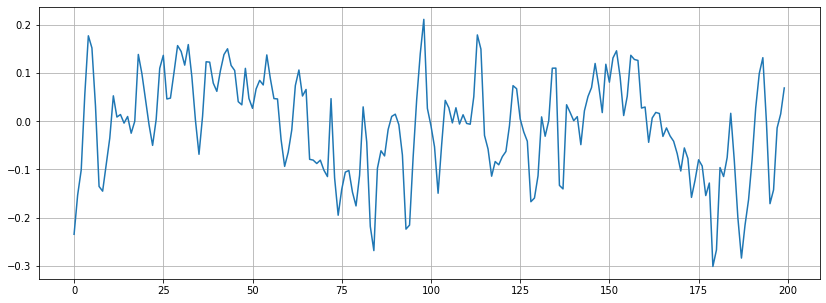

In [70]:
start = 1000
end = 1200
plt.figure(figsize=(14,5))
plt.plot(metal_series[start:end]) # Plot the zero crossing rate: measure of the frequency content of the signal
plt.grid()

## Features manipulation ##

### Using "scikit-learn" ###

In [13]:
class_list = df.iloc[:,-1]

convertor = LabelEncoder() # Encode target labels with value between 0 and n_classes-1
y = convertor.fit_transform(class_list) # Fit label encoder and return encoded labels

fit = StandardScaler() # Standardize features by removing the mean and scaling to unit variance
X = fit.fit_transform(np.array(df.iloc[:,:-1], dtype=float)) # Fit to data and transform it

print(df.iloc[:,:-1]) # show which features are being used

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

## Model building ##

### Training and test set ###

Method: 33% split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [15]:
def trainModel(model, epochs, optimizer):
    batch_size = 128
    #callback = myCallback()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics='accuracy')
    return model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

In [16]:
def plotValidate(history):
    print("Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [17]:
model = k.models.Sequential([k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)), k.layers.Dropout(0.2),
                            k.layers.Dense(256, activation='relu'), k.layers.Dropout(0.2),
                            k.layers.Dense(128, activation='relu'), k.layers.Dropout(0.2),
                            k.layers.Dense(64, activation='relu'), k.layers.Dropout(0.2),
                            k.layers.Dense(10, activation='softmax')])
print(model.summary())

model_history = trainModel(model=model, epochs=600, optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

### Model Evaluation ###

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=128)

print("\nTest loss: ", test_loss)
print("\nTest accuracy: ", test_acc*100)

26/26 [==============================] - 0s 2ms/step - loss: 0.5292 - accuracy: 0.9263

Test loss:  0.5291786193847656

Test accuracy:  92.62966513633728


## Conclusion ##

## References ##

1. D. A. Huang, A. A. Serafini, E. J. Pugh. Music Genre Classification. 2018. Standford University.
2. Librosa. https://librosa.org/doc/latest/index.html